In [39]:
import torch
import gym
from gym import envs
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

In [ ]:
for env in envs.registry.all():
    print(env)

In [40]:
env = gym.make('PongNoFrameskip-v0')
env.observation_space

Box(210, 160, 3)

In [3]:
env = gym.make('PongNoFrameskip-v0')
observation = env.reset()


env.render()
print(observation)
action = env.action_space.sample()
a, b, c, d = env.step(action)
print(a,b,c,d)

env.close()


[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 ...

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]]
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 ...

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ..

In [ ]:
#Run to see visual

for i_episode in range(2):
    observation = env.reset()
    for t in range(1000):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, log = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()


In [ ]:
env = gym.make('PongNoFrameskip-v0')
observation = env.reset()


# env.render()
print(observation)
# action = env.action_space.sample()
# a, b, c, d = env.step(action)
# print(a,b,c,d)

env.close()


In [1]:
env.action_space

NameError: name 'env' is not defined

In [ ]:
type(observation)

In [ ]:
pobservation = torch.from_numpy(observation)
pobservation

In [ ]:
flattened_pobservation = pobservation.view(1,-1).float()

In [ ]:
lenobs = len(flattened_pobservation[0])
lenobs

In [ ]:
flattened_pobservation.shape

In [ ]:
preds = ANNmodel(flattened_pobservation)
preds

In [ ]:
#Sampling from actions
action = np.random.choice(np.array([0,1]), p = preds.view(2,).data.numpy())
action

In [ ]:
# Alternate model
ANNmodel2 = nn.Sequential(
           nn.Linear(lenobs, 2000),
           nn.LeakyReLU(),
           nn.Linear(2000,2),
           nn.LeakyReLU(),
           nn.Softmax(dim = 1))

In [ ]:
lenobs = 100800
ANNmodel1 = nn.Sequential(
           nn.Linear(lenobs, 2000),
           nn.Sigmoid(),
           nn.Linear(2000,2),
           nn.Sigmoid(),
           nn.Softmax(dim = 1))

In [2]:
lenobs = 100800
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(lenobs,25)
        self.l2 = nn.Linear(25,50)
        self.actor_lin1 = nn.Linear(50,2)
        self.l3 = nn.Linear(50,25)
        self.critic_lin1 = nn.Linear(25,1)

    def forward(self,x):
        x = F.normalize(x,dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.softmax(self.actor_lin1(y),dim=0)
#         actor = F.log_softmax(self.actor_lin1(y),dim=0)
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c))
        return actor, critic

In [4]:
env = gym.make('PongNoFrameskip-v0')
moveMapping = {
    0:2,
    1:3
}

model = ActorCritic()
optimizer = optim.Adam(lr=1e-4,params=model.parameters())

'''
loss = Variable(loss, requires_grad = True)
actor_loss = Variable(actor_loss, requires_grad = True)
critic_loss = Variable(critic_loss, requires_grad = True)
'''

for i_episode in range(2):
#     reward = 0.0
    values = []
    rewards = []
    logprobs = []
    observation = env.reset()
    print('---------------')
    done = False
    t = 0
    while done == False:
        t+=1
#         print(t)
        pobservation = torch.from_numpy(observation)
        flattened_pobservation = pobservation.view(-1).float()
        policy, value = model(flattened_pobservation)
#         print(policy)
        values.append(value)
        action = np.random.choice(np.array([0,1]), p = policy.view(2,).data.numpy())
        logprobs.append(policy.view(-1)[action])
#         print('Action: {}'.format('right' if action==2 else 'left'))
        observation, reward, done, log = env.step(moveMapping[action])
        rewards.append(reward)
#         print('{}.Reward: {}'.format(t,reward))
#         print('---')
        if done:
            print('Episode:{} State:{} Reward:{}'.format(i_episode,t,reward))
            print("Episode finished after {} timesteps".format(t+1))    
            break
        
      
    # Reversing because earlier actions have greater value
    torch_values = torch.tensor(values, requires_grad = True).view(-1).flip(0)
    torch_rewards = torch.tensor(rewards, requires_grad = True).flip(0)
    torch_logprobs = torch.tensor(logprobs, requires_grad = True).flip(0)
    
    
    returns = []
    gamma = 0.95
    clc = 0.1
    ret = torch.tensor([0])
    for r in torch_rewards:
        ret = r + gamma*ret
        returns.append(ret)
    returns = torch.tensor(returns, requires_grad = True)
    returns = F.normalize(returns,dim=0)
    actor_loss = -1*torch_logprobs * (returns - torch_values)
    critic_loss = torch.pow(torch_values - returns,2)
    loss = actor_loss.sum() + clc*critic_loss.sum()
    print('Loss: {}'.format(loss))
#     print('Starting Backpropagation')
    loss.backward()
    optimizer.step()
#     print('Completed Backpropagation')
    done = not done
    
    

---------------
Episode:0 State:3056 Reward:-1.0
Episode finished after 3057 timesteps
Loss: -113.89744567871094
---------------
Episode:1 State:3056 Reward:-1.0
Episode finished after 3057 timesteps
Loss: -113.91683197021484


In [ ]:
env.close()

In [ ]:
#################### Checking operations of pong #######################3

In [5]:
 env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [ ]:
##########################################################################

In [ ]:
############################# Experimenting with Backpropagation ######################

inp = torch.tensor([2.,3.]).float()
weights = torch.tensor([1.,9.], requires_grad = True).float()
print("Params: ",weights)
gt = torch.tensor([6.])
print("Ground truth: ",gt)
out = torch.dot(inp,weights)
print("Prediction: ",out)

error = (gt - out)



In [ ]:
optimizer = optim.SGD([weights],lr = 0.1)
optimizer.zero_grad()
error.backward()
optimizer.step()

# print(ANNmodel.weight.grad)
weights.grad, out.grad

In [ ]:
#Weights after one round of backpropagation
weights

In [ ]:
# Checking variables with requires_grad
inp.requires_grad, weights.requires_grad, gt.requires_grad, out.requires_grad, error.requires_grad

In [ ]:
###############################################################################################

In [ ]:
############################ Manually setting gradients #######################################

In [ ]:
MinorModel2 = nn.Sequential( 
             nn.Linear(2,1, bias = False))

inp = torch.tensor([2.,3.])
out = MinorModel(inp)
out

In [ ]:
for params in MinorModel2.parameters():
    print(params)

In [ ]:
MinorModel2[0].weight

In [ ]:
MinorModel2[0].weight.grad = torch.Tensor([1,2]).view(1,-1)

In [ ]:
o2 = optim.SGD(MinorModel2.parameters(), lr=0.1)

o2.step()

In [ ]:
for params in MinorModel2.parameters():
    print(params)

In [ ]:
########################################################

In [ ]:
####################### Testing ########################

In [ ]:

MinorModel = nn.Sequential( 
             nn.Linear(2,1, bias = False))

inp = torch.tensor([2.,3.])
out = MinorModel(inp)
out


In [ ]:

for name, params in MinorModel.named_parameters():
    print(name, params)
    


In [ ]:

for params in MinorModel.parameters():
    print(params)
    print(type(params))
    
print(MinorModel.parameters())


In [ ]:
#######################################################

In [ ]:
############################ Experimentations ###############################################

# from torch.distributions import Categorical
# a = torch.tensor([20,20,20,20,20]).float()
# # Note that this is equivalent to what used to be called multinomial
# m = Categorical(a)

# li = [0,0,0,0,0]


# for i in range(100):
#     li[m.sample().item()] +=1
    
# li

# a = torch.tensor(3)
# a.item()


#############################################################################################

Experimentation for cropping and grayscaling

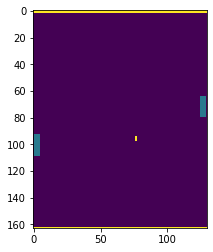

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms
import torch 
import gym

env = gym.make('PongNoFrameskip-v0')
observation = env.reset()
for _ in range(750):
    observation, reward, done, log = env.step(1)


tobservation = torch.from_numpy(observation).permute(2,0,1)
# observation.shape # 210, 160, 3
# tobservation.shape # 210 160 3

preprocess = transforms.Compose([
    transforms.ToPILImage(),
])

cropped_image = transforms.functional.crop(preprocess(tobservation),32,15,163,130)

gs_image = transforms.functional.to_grayscale(cropped_image)

gs_tensor = transforms.ToTensor()(gs_image)







# gs_tensor.shape
plt.imshow(gs_image)


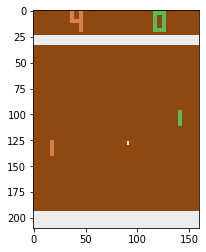

In [12]:
plt.imshow(tobservation.permute(1,2,0))

In [68]:
observation = env.reset()
eps = 0

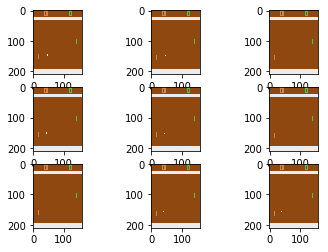

In [83]:
import matplotlib.pyplot as pyplot
%matplotlib inline


for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    tobservation = torch.from_numpy(observation)
    pyplot.imshow(tobservation)
    observation, reward, done, log = env.step(1)
    eps+=1
    
pyplot.show()

In [84]:
eps

99

Parallelized training experiments

In [ ]:
import concurrent.futures
import torch
import torch.nn as nn
import torch.optim as optimizer
from torch.distributions import Categorical

    
class mymodel(nn.Module):
    def __init__(self, ran):
        super(mymodel,self).__init__()
        torch.random.manual_seed(ran)
        self.weight = nn.Linear(3,2)
        self.out = None
        
    def forward(self, X):
        self.out = self.weight(X)
        self.out = nn.Softmax(dim = 0)(out)
        return self.out


        
def doTrain(model, ran, X):     
    a1 = model(ran)
    return list(a1.parameters())

X = torch.randn(20,3)


updatedParams = []
results = []


with concurrent.futures.ProcessPoolExecutor() as executor:
    for i in range(5):
        results.append(executor.submit(doTrain, mymodel, int((torch.randn(1)**2)*200), X[i*4:(i+1)*4]))
    

    for f in concurrent.futures.as_completed(results):
        updatedParams.append(f.result())


In [ ]:
updatedW = torch.zeros(2,3)
updatedB = torch.zeros(2)

for i in updatedParams:
    updatedW+=i[0]
for i in updatedParams:
    updatedB+=i[1]
    
updatedW/=5.0
updatedB/=5.0

updatedW, updatedB

In [ ]:
# updatedWts = (updatedParams[0][0]+updatedParams[1][0]+updatedParams[2][0]+updatedParams[3][0]+updatedParams[4][0])/5.0
# updatedBias = (updatedParams[0][1]+updatedParams[1][1]+updatedParams[2][1]+updatedParams[3][1]+updatedParams[4][1])/5.0
# updatedWts, updatedBias